In [225]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm
from skimage.feature import hog
from skimage.color import rgb2grey
import scikitplot as skplt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
import timeit
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report
import mahotas
import pickle

In [2]:
# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [3]:
# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(image).mean(axis=0)
    # return the result
    return haralick

1858


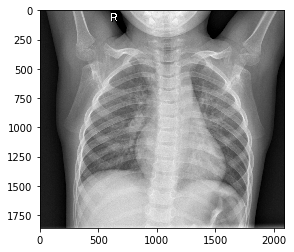

7
13
0.5750092131356705
1152
1172


In [54]:
DATADIR = "C:/Users/yashh/Data Analytics/Project/chest-xray-pneumonia/chest_xray/train"
CATEGORIES = ["NORMAL","PNEUMONIA"]
img_array ={}
for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR,category)  # create path to dogs and cats
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        print(len(img_array))
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()
        IMG_SIZE = 200
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        grey_bombus = rgb2grey(new_array)
        haralick = mahotas.features.haralick(grey_bombus).mean(axis=0)
        fv_hu_moments = fd_hu_moments(new_array)
        print(len(fv_hu_moments))
        fv_haralick   = fd_haralick(new_array)
        print(len(fv_haralick))
        #print(haralick)
        histogram_features, img= hog(grey_bombus, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualize=True)
        print(histogram_features[0])
        print(len(histogram_features))
        global_feature = np.hstack([fv_haralick, fv_hu_moments,histogram_features])
        print(len(global_feature))
        #print(fd)
        #plt.imshow(hog_image, cmap=mpl.cm.gray)
        #plt.show()  # display!
        #bombus_features = create_features(new_array)
        #print(bombus_features)
        
        break  # we just want one for now so break
    break  #...and one more!

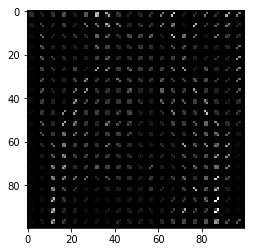

In [5]:
# run HOG using our greyscale bombus image
IMG_SIZE = 100

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

grey_bombus = rgb2grey(new_array)
fd, hog_image = hog(grey_bombus, orientations=8, pixels_per_cell=(5, 5),
                    cells_per_block=(1, 1), visualize=True)
plt.imshow(hog_image, cmap=mpl.cm.gray)

In [226]:
def transform_images(grayscale=True):
    """ convert color images to grayscale, resize"""
    infected = (image for image in os.listdir('Parasitized'))
    uninfected = (image for image in os.listdir('Uninfected'))
    data = []
    labels = []
    for idx, img in enumerate(infected):
        if grayscale:
            image = cv2.imread('./Parasitized/' + img, cv2.IMREAD_GRAYSCALE)
        else:
            image = cv2.imread('./Parasitized/' + img)
        resize_img = resize(image, (50,50))
        data.append(resize_img)
        labels.append(1)

    for idx, img in enumerate(uninfected):
        if grayscale:
            image = cv2.imread('./Uninfected/' + img, cv2.IMREAD_GRAYSCALE)
        else:
            image = cv2.imread('./Uninfected/' + img)
        resize_img = resize(image, (50,50))
        data.append(resize_img)
        labels.append(0)
    
    cells = np.array(data).astype('float32')
    labels = np.array(labels).astype('int32')
    
    return cells, labels

In [206]:
def create_histogram_vectors(grayscale_data):
    """ create 9 bins of gradients """
    hist = np.zeros((grayscale_data.shape[0],20))  # initialize 2dim array of nrow(grayscale_image) x 9
    for  idx, image_data in enumerate(grayscale_data):
        counts, bins = np.histogram(image_data, bins=20,range=(0.001,1))  # range excludes 0.0--black gradient
        hist[idx] = counts / np.sum(counts)  # normalize the gradients by the sum of all the gradients to get a value between 0 - 1
    hist = hist.astype('float32')
    return hist

In [227]:
training_data = []
IMG_SIZE =200
CATEGORIES = ["NORMAL","PNEUMONIA"]
DATADIR = "C:/Users/yashh/Data Analytics/Project/chest-xray-pneumonia/chest_xray/train"

def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size

                fv_hu_moments = fd_hu_moments(new_array)
                fv_haralick   = fd_haralick(new_array)

                #haralick = mahotas.features.haralick(new_array).mean(axis=0)
                #histogram_features, hist_image= hog(new_array, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
                global_feature = np.hstack([fv_haralick, fv_hu_moments])
                training_data.append([global_feature,class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass

create_training_data()

print(len(training_data))

100%|██████████████████████████████████████████████████████████████████████████████| 3875/3875 [01:54<00:00, 33.95it/s]


5216


In [228]:
len(testing_data[0][0])

200

In [239]:
testing_data = []
IMG_SIZE =200
CATEGORIES = ["NORMAL","PNEUMONIA"]
DATADIR = "C:/Users/yashh/Data Analytics/Project/chest-xray-pneumonia/chest_xray/test"

def create_testing_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size

                fv_hu_moments = fd_hu_moments(new_array)
                fv_haralick   = fd_haralick(new_array)

                #haralick = mahotas.features.haralick(new_array).mean(axis=0)
                #histogram_features, hist_image= hog(new_array, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
                global_feature = np.hstack([fv_haralick, fv_hu_moments])
                testing_data.append([global_feature,class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass

create_testing_data()

print(len(testing_data))


 55%|████████████████████████████████████████████▎                                   | 216/390 [00:06<00:06, 27.88it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:11<00:00, 33.69it/s]

624


In [234]:
testing_data = []
IMG_SIZE =200
CATEGORIES = ["NORMAL","PNEUMONIA"]
DATADIR = "C:/Users/yashh/Data Analytics/Project/chest-xray-pneumonia/chest_xray/test"

def create_testing_data():
    for category in CATEGORIES:  

        path = os.path.join(DATADIR,category) 
        class_num = CATEGORIES.index(category) 

        for img in tqdm(os.listdir(path)): 
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size

                fv_hu_moments = fd_hu_moments(new_array)
                fv_haralick   = fd_haralick(new_array)

                #histogram_features, hist_image= hog(new_array, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
                global_feature = np.hstack([fv_haralick, fv_hu_moments])
        
                testing_data.append([new_array,class_num]) 
            except Exception as e:  
                pass

create_testing_data()

print(len(testing_data))

100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.89it/s]


624


In [9]:
pickle_out = open("SVM_train.pickle","wb")
pickle.dump(training_data, pickle_out)
pickle_out.close()

In [10]:
pickle_out = open("SVM_test.pickle","wb")
pickle.dump(testing_data, pickle_out)
pickle_out.close()

In [152]:
training_data= pickle.load(open("SVM_train.pickle","rb"))
testing_data= pickle.load(open("SVM_test.pickle","rb"))

In [240]:
import random
random.shuffle(training_data)
random.shuffle(testing_data)
X = []
y = []
for features,label in training_data:
    X.append(features)
    y.append(label)

X_test = []
y_test = []
for features,label in testing_data:
    X_test.append(features)
    y_test.append(label)

#X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
#X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [241]:
train_x, test_x, train_y, test_y = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=155)

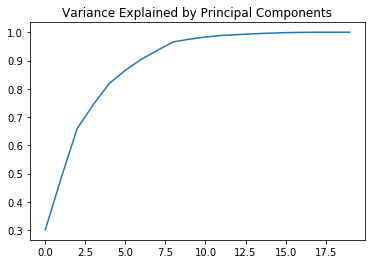

In [242]:
pre_process = StandardScaler()
pre_process.fit(X)
X = pre_process.transform(X)
X_test = pre_process.transform(X_test)


pca = PCA()
pca.fit(X)
fig, ax = plt.subplots()  # plot just one subplot
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_title('Variance Explained by Principal Components')
plt.show()


In [277]:
pickle_out = open("sd.pickle","wb")
pickle.dump(pre_process, pickle_out)
pickle_out.close()
pickle_out = open("pca.pickle","wb")
pickle.dump(pca, pickle_out)
pickle_out.close()

In [243]:
pca = PCA(n_components=15)
pca.fit(X)
X = pca.transform(X)
X_test = pca.transform(X_test)

In [279]:
X_test[0]

array([ 1.29473863, -1.04935086,  0.56336016, -1.18927883, -0.04807453,
       -0.08252254, -0.10669971,  0.16333682,  0.11300673, -0.09516035,
       -0.36288825, -0.04202226,  0.08402851, -0.2050365 , -0.37619661])

In [15]:
def grid_search():
    standardized_data = StandardScaler()
    pca = PCA(n_components=15)
    svc = SVC()
    pipe = Pipeline([('standardized_data', standardized_data),
                     ('pca', pca),
                     ('svc', svc)])
    
    start = timeit.default_timer()
    svm_parameters = [{'svc__C':[0.1,1.,10.,100.], 'svc__kernel':['rbf'], 'svc__gamma':[0.1,1.,10.,100.], 
                       'svc__probability':[True], 'svc__random_state':[155]}]  
    grid_search_svm = GridSearchCV(pipe, svm_parameters, cv=3, n_jobs=4)
    grid_search_svm.fit(train_x, train_y)
    print(f'Runtime for SVM:{timeit.default_timer() - start}')
    return grid_search_svm

In [ ]:
C = np.logspace(-2, 2, 7)
gamma = np.logspace(-2, 2, 7)
standardized_data = StandardScaler()
pca = PCA(n_components=15)
svc = SVC(kernel = "rbf")
pipe = Pipeline([('standardized_data', standardized_data),
                     ('pca', pca)])
X = pipe.fit_transform(X)
param_grid = {'C': C,
             'gamma':gamma,
             'probability':[True]}
grid = GridSearchCV(svc, param_grid, cv=6, verbose=10, scoring='accuracy')
grid.fit(X, y)

In [38]:
grid.best_params_

{'C': 100.0, 'gamma': 0.01, 'probability': True}

In [39]:
grid.best_score_

0.9027663653793482

In [40]:
svm_model = grid_search()
svm_model.best_params_

Runtime for SVM:33.40741189999994


{'svc__C': 100.0,
 'svc__gamma': 0.1,
 'svc__kernel': 'rbf',
 'svc__probability': True,
 'svc__random_state': 155}

In [216]:
#X = pre_process.transform(X)
#pca = PCA(n_components=15)
svc = SVC(kernel = "rbf")
pipe = Pipeline([('standardized_data', standardized_data)])
X = pipe.fit_transform(X)

In [250]:
model =SVC(C= 100.0,gamma= 0.01, kernel='rbf',probability=True)

In [251]:
model.fit(X,y)

SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [255]:
pickle_out = open("SVM_model.pickle","wb")
pickle.dump(model, pickle_out)
pickle_out.close()

In [280]:
svm_results = model.predict(X_test[0])

ValueError: Expected 2D array, got 1D array instead:
array=[ 1.29473863 -1.04935086  0.56336016 -1.18927883 -0.04807453 -0.08252254
 -0.10669971  0.16333682  0.11300673 -0.09516035 -0.36288825 -0.04202226
  0.08402851 -0.2050365  -0.37619661].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [253]:
print(f"Accuracy: {accuracy_score(y_test, svm_results)}")
print(f"Recall: {recall_score(y_test, svm_results)}")
print(classification_report(y_test, svm_results))

Accuracy: 0.7772435897435898
Recall: 0.9205128205128205
              precision    recall  f1-score   support

           0       0.80      0.54      0.64       234
           1       0.77      0.92      0.84       390

    accuracy                           0.78       624
   macro avg       0.79      0.73      0.74       624
weighted avg       0.78      0.78      0.77       624



In [254]:
confusion_matrix(y_test,svm_results)

array([[126, 108],
       [ 31, 359]], dtype=int64)

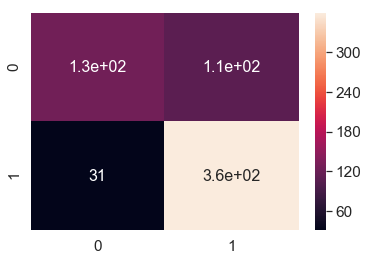

In [2]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
array = [[126,108],
         [31,359]]

df_cm = pd.DataFrame(array, range(2), range(2))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

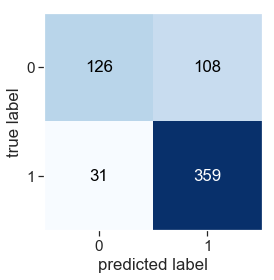

In [4]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

binary1 = np.array([[126, 108],
                   [31, 359]])

fig, ax = plot_confusion_matrix(conf_mat=binary1)
plt.show()

In [47]:
def plot_roc(probs, label):
    fpr = {}
    tpr = {}
    roc_auc = {}
    # results = [n for n in np.ravel(test_y) if n == label]
    for i in range(2):  #  binary classifier
        fpr[i], tpr[i], _ = roc_curve(test_y, probs[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        print(roc_auc[i])
        

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), svm_results.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    fig, ax = plt.subplots()
    ax.plot(fpr[label], tpr[label], color='darkorange', lw=2, label='ROC curve {:.2f}'.format(roc_auc[label]))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [48]:
predict_prob = svm_model.predict_proba(test_x)

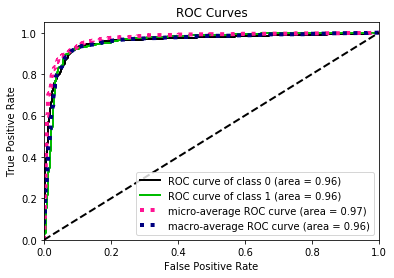

In [49]:
import scikitplot as skplt
skplt.metrics.plot_roc(test_y, predict_prob)
plt.show()

In [50]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib

In [51]:
num_trees = 100
test_size = 0.10
seed      = 9
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

In [52]:
results = []
names   = []
scoring    = "accuracy"
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

C:\Users\yashh\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\yashh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\yashh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

In

LR: 0.782225 (0.057981)


C:\Users\yashh\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


LDA: 0.880755 (0.012783)


C:\Users\yashh\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KNN: 0.785087 (0.013504)


C:\Users\yashh\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


CART: 0.851223 (0.011500)


C:\Users\yashh\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RF: 0.886699 (0.009672)


C:\Users\yashh\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


NB: 0.830714 (0.019250)


C:\Users\yashh\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


SVM: 0.742910 (0.015337)


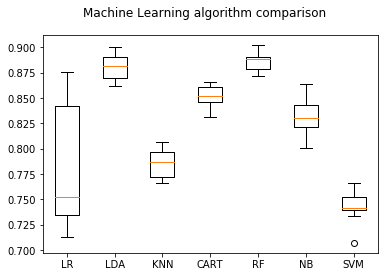

In [53]:
fig = plt.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [54]:
print()

In [256]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt

In [257]:
logistic_regression= LogisticRegression()
logistic_regression.fit(X,y)
y_pred=logistic_regression.predict(X_test)

In [259]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.7676282051282052
Recall: 0.9179487179487179
              precision    recall  f1-score   support

           0       0.79      0.52      0.63       234
           1       0.76      0.92      0.83       390

    accuracy                           0.77       624
   macro avg       0.78      0.72      0.73       624
weighted avg       0.77      0.77      0.75       624



In [273]:
C_param_range = [0.001,0.01,0.1,1,10,100,1000]
for i in C_param_range:
    
    # Apply logistic regression model to training data
    logistic_regression= LogisticRegression(penalty = 'l2', C = i,random_state = 0)
    logistic_regression.fit(X,y)
    # Predict using model
    y_pred = logistic_regression.predict(X_test)
    print(i)
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

0.001
Accuracy: 0.7532051282051282
0.01
Accuracy: 0.7724358974358975
0.1
Accuracy: 0.7660256410256411
1
Accuracy: 0.7676282051282052
10
Accuracy: 0.7644230769230769
100
Accuracy: 0.7628205128205128
1000
Accuracy: 0.7628205128205128


In [275]:
logistic_regression= LogisticRegression(penalty = 'l2', C = 0.01,random_state = 0)
logistic_regression.fit(X,y)
    # Predict using model
y_pred = logistic_regression.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.7724358974358975
Recall: 0.9384615384615385
              precision    recall  f1-score   support

           0       0.83      0.50      0.62       234
           1       0.76      0.94      0.84       390

    accuracy                           0.77       624
   macro avg       0.79      0.72      0.73       624
weighted avg       0.78      0.77      0.76       624

